# Canucks - Extended Feature Selection
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 17, 2022

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard StellarAlgo retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ···········


In [3]:
lkupclientid = 7 # Canucks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32927, 58)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32927 entries, 0 to 32926
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              32927 non-null  int64  
 1   dimCustomerMasterId       32927 non-null  int64  
 2   customerNumber            32927 non-null  object 
 3   year                      32927 non-null  int64  
 4   productGrouping           32927 non-null  object 
 5   totalSpent                32927 non-null  float64
 6   recentDate                32927 non-null  object 
 7   attendancePercent         32927 non-null  float64
 8   renewedBeforeDays         32927 non-null  int64  
 9   isBuyer                   32927 non-null  object 
 10  source_tenure             32927 non-null  int64  
 11  tenure                    32927 non-null  int64  
 12  distToVenue               0 non-null      object 
 13  totalGames                32927 non-null  int64  
 14  recenc

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "NumberofGamesPerSeason",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 11)
Unseen Data For Predictions: (4172, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
          "distToVenue",
          "recency",
          "source_tenure",
          "renewedBeforeDays",
          "NumberofGamesPerSeason",
          "totalSpent"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8236,0.9031,0.8763,0.8025,0.8377,0.6454,0.6485,0.5690
lr,Logistic Regression,0.6656,0.7310,0.6302,0.6962,0.6608,0.3328,0.3350,0.4680


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8393,0.9084,0.8755,0.8257,0.8498,0.6773,0.6787
1,0.8294,0.9143,0.8851,0.8056,0.8435,0.6568,0.6603
2,0.8149,0.8932,0.8621,0.7979,0.8287,0.6281,0.6303
3,0.8239,0.9065,0.8831,0.7990,0.8389,0.6457,0.6497
4,0.8348,0.9154,0.8956,0.8074,0.8492,0.6677,0.6721
5,0.8134,0.8970,0.8582,0.7979,0.8269,0.6252,0.6271
6,0.8342,0.9053,0.8851,0.8127,0.8473,0.6668,0.6697
7,0.8138,0.8969,0.8602,0.7975,0.8276,0.6259,0.6280
8,0.8283,0.9065,0.8908,0.8010,0.8435,0.6544,0.6590
9,0.8044,0.8878,0.8677,0.7802,0.8216,0.6064,0.6106


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5112, 58)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,pkgupgrade_status,auto_renewal,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
27815,7,7025,141998,2021,Full Season,10186.8,2021-12-14,1.055556,102,TRUE,...,0,0,0.0,1,46,10,0,1,0.2965,0.7035
27816,7,7570,6905653,2021,Full Season,15904.7,2021-12-14,1.058824,102,TRUE,...,0,0,0.0,1,46,10,0,1,0.1739,0.8261
27817,7,8651,148070,2021,Full Season,35429.8,2021-12-14,1.041667,102,TRUE,...,0,0,0.0,1,46,10,0,1,0.0166,0.9834
27818,7,9419,3681882,2021,Quarter,2620.0,2021-12-06,1.000000,20,TRUE,...,0,0,0.0,1,46,10,0,0,0.8877,0.1123
27819,7,9798,8615657,2021,Quarter,1487.5,2021-12-06,1.000000,18,TRUE,...,0,0,0.0,1,46,10,0,0,0.7510,0.2490


In [11]:
new_predictions["Label"].value_counts()

1    2790
0    2322
Name: Label, dtype: int64

In [14]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       1210
(0.2, 0.4]       1090
(0.4, 0.6]       1054
(0.6, 0.8]       1036
(-0.001, 0.2]     722
Name: Score_1, dtype: int64

In [12]:
#new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

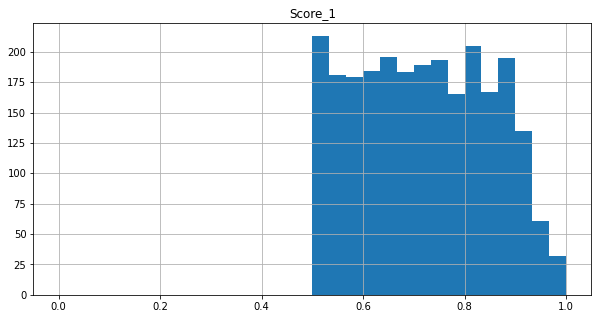

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

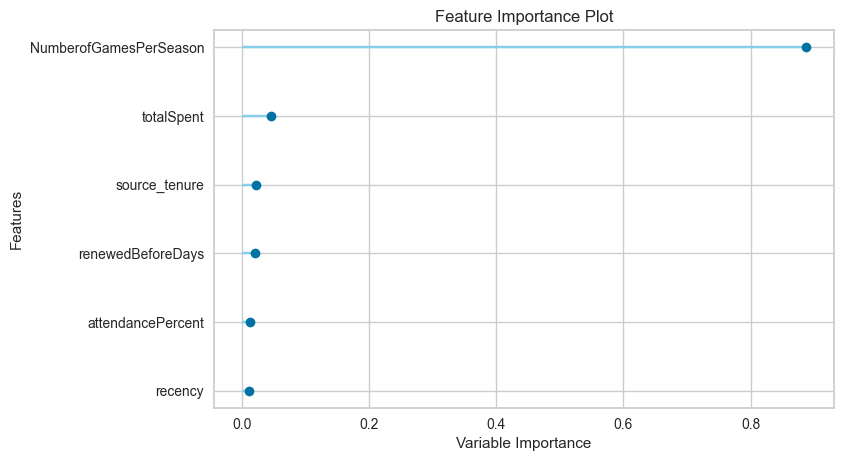

In [14]:
plot_model(best_model, plot='feature')

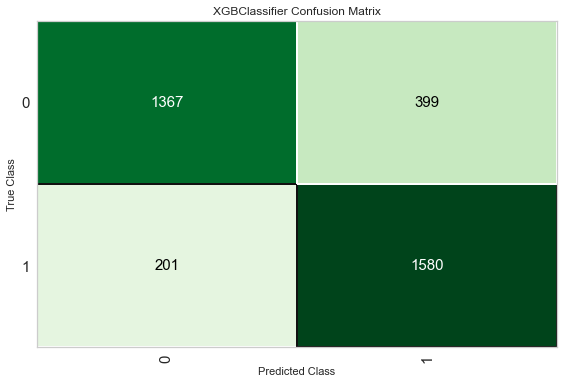

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?